In [1]:
from sqlalchemy import create_engine
import pymysql
from urllib.parse import quote
import pandas as pd
import tkinter, tkinter.ttk, pymysql, paramiko
from tkcalendar import Calendar
from sshtunnel import SSHTunnelForwarder
from sqlalchemy import create_engine
import time
from tqdm import tqdm
from datetime import datetime, date, timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import cm
import random
from sklearn.preprocessing import MinMaxScaler
random.seed(0)

In [2]:
pkeyfilepath = '/Users/gitple/.ssh/id_rsa' ######################### ssh_key.pem 파일 경로 넣으시면 됩니다.
mypkey = paramiko.RSAKey.from_private_key_file(pkeyfilepath)
sql_hostname = 'db-8j8d2-fkr.cdb.fin-ntruss.com'
sql_username = 'wkdtjdgus2142'            ######################### sql_username 입력하시면 됩니다.
sql_password = '?!0hLtR$_i8onochu=aC'            ######################### sql_password 입력하시면 됩니다.
sql_main_database = 'betterday_db'
sql_port = 3306
ssh_host = '10.0.1.14'
ssh_user = 'wkdtjdgus2142'                ######################### ssh_user 입력하시면 됩니다.
ssh_port = 22

# soslSuregi97o#rop0n0

### 투자상품 총 자산

In [15]:
with SSHTunnelForwarder(
        (ssh_host, ssh_port),
        ssh_username=ssh_user,
        ssh_pkey=mypkey,
        remote_bind_address=(sql_hostname, sql_port)) as tunnel:
        con = pymysql.connect(host='127.0.0.1', user=sql_username,
            passwd=sql_password, db=sql_main_database,
            port=tunnel.local_bind_port)
        df = ["1559","1560"] # get To_Date, From_Date
        ACCOUNT_LIST =[]
        for item in df:
            print("I'm running")
            print(item)
            sql = """
           SELECT mut.BDAY_CUST_ID, bc.BIRTH_DD 
            ,SUM(IF(IFNULL(CURRENCY_CODE, 'KRW')='KRW',EVAL_AMT,EVAL_AMT*(SELECT RATE FROM betterday_db.BD_EXCHANGE_RATE B
                                WHERE B.CURRENCY_CODE = miap.CURRENCY_CODE
                                AND date_format(CRT_DT,"%Y-%m-%d") = miap.BASE_DATE 
                                limit 1))) AS AMT_SUM
            FROM MD_INVEST_ACCOUNTS mia, MD_USER_TOKEN mut, MD_INVEST_ACCOUNTS_PRODUCTS miap , BDAY_CUST bc 
            WHERE mia.TOKEN_ID = mut.ID  AND miap.INVEST_ACCOUNTS_ID = mia.ID AND bc.ID = mut.BDAY_CUST_ID
            GROUP BY mut.BDAY_CUST_ID;
            """.format(str(item[0]))
            cur = con.cursor()
            cur.execute(sql)
            invest_data = cur.fetchall()

I'm running
1559
I'm running
1560


In [17]:
with SSHTunnelForwarder(
        (ssh_host, ssh_port),
        ssh_username=ssh_user,
        ssh_pkey=mypkey,
        remote_bind_address=(sql_hostname, sql_port)) as tunnel:
        con = pymysql.connect(host='127.0.0.1', user=sql_username,
            passwd=sql_password, db=sql_main_database,
            port=tunnel.local_bind_port)
        df = ["1559","1560"] # get To_Date, From_Date
        ACCOUNT_LIST =[]
        for item in df:
            print("I'm running")
            print(item)
            sql = """
            SELECT mut.BDAY_CUST_ID, SUM(IF(mbadd.BALANCE_AMT<0,0,mbadd.BALANCE_AMT)) FROM MD_BANK_ACCOUNTS_DEPOSIT_DETAIL mbadd, MD_BANK_ACCOUNTS mba , MD_USER_TOKEN mut 
            WHERE mbadd.BANK_ACCOUNTS_ID = mba.ID  AND mba.TOKEN_ID = mut.ID
            AND mba.IS_CONSENT=1
            AND mba.ACCOUNT_TYPE IN (1001,1002,1003,1999,2001,2002,2003,2004,2999)
            AND mba.ACCOUNT_STATUS =1
            GROUP BY mut.BDAY_CUST_ID;
            """.format(str(item[0]))
            cur = con.cursor()
            cur.execute(sql)
            all_amt = cur.fetchall()

I'm running
1559
I'm running
1560


In [ ]:
invest_data = pd.DataFrame(invest_data)
all_amt = pd.DataFrame(all_amt)

invest_data.columns = ['ID','year','invest_amt']
all_amt.columns = ['ID','계좌액수']

data = pd.merge(all_amt, invest_data,how='inner',on='ID')

invest_data['year'] = invest_data.year.apply(lambda x: datetime.now().year - x.year)
data['invest_rate']=data['invest_amt']/(data['계좌액수']+data['invest_amt'])

In [213]:
css_all = pd.read_csv('../페니로이스/css_data/css_all_0913.csv',index_col=0)
# css_all = pd.DataFrame(css_all)
# css_all.columns = ['ID','계좌액수','M0_입금','M0_출금','M1_입금','M1_출금']
# css_all['m_sav']=css_all['M0_입금']-css_all['M0_출금']-(css_all['M1_입금']-css_all['M1_출금'])


data = pd.merge(css_all[['ID','m_sav']], data3, how='inner', on='ID')
data = pd.merge(all_amt[['ID','계좌액수']], data, how='inner', on='ID')

data['invest_rate']=data['eval_amt']/(data['계좌액수']+data['eval_amt'])
data = data.dropna().reset_index().drop('index',axis=1)

### ver02.

In [214]:
def alpha_bar( mu, sigma, theta, r):
    return (mu-r)/(theta*sigma*sigma)

def theta_ftn(x):
    theta = np.exp(-7.34*x**3 + 12.13*x**2 + -6.74*x + 1.95)
    if theta >7:
        theta =7
    elif theta<1:
        theta=1
    return theta

In [215]:
def phi_ftn ( t_hat, t_max, T, M_save, t_max_amt, T_amt):
    if t_hat < t_max :
        if t_max_amt > 12*M_save :
            a1 = (t_max_amt - 12 * M_save) / (t_max - t_hat)
            b1 = (12 * M_save - t_max_amt) / (t_max - t_hat) * t_max + t_max_amt
            a2 = (T_amt - t_max_amt) / (T - t_max)
            b2 = (t_max_amt - T_amt) / (T - t_max) * T + T_amt
        else :
            t_max_amt = t_max_amt*(1+0.2)
            T_amt = T_amt*(1+0.2)
            a1 = (t_max_amt - 12 * M_save) / (t_max - t_hat)
            b1 = (12 * M_save - t_max_amt) / (t_max - t_hat) * t_max + t_max_amt
            a2 = (T_amt - t_max_amt) / (T - t_max)
            b2 = (t_max_amt - T_amt) / (T - t_max) * T + T_amt
    else :
        a1 = 0
        b1 = 0
        a2 = (T_amt - 12 * M_save)/(T - t_hat)
        b2 = (12 * M_save - T_amt)/(T - t_hat) + T_amt
    return (a1,b1,a2,b2)

In [216]:
def glide_path ( t, t_hat, mu, sigma, r, theta, t_max, T, t_max_amt, T_amt, M_save, X0) :
    glide_lst =[]
    alpha = alpha_bar(mu, sigma, theta, r)
    (a1, b1, a2, b2) = phi_ftn(t_hat, t_max, T, M_save, t_max_amt, T_amt)
    if t_hat < t_max :
        while t < T:
            int_f = alpha * mu * (0.5 * a2 * T * T + b2 * T + 0.5 * (a1 - a2) * t_max * t_max + (b1 - b2) * t_max) * t
            - alpha * mu * (1 / 6 * a1 * t * t + 0.5 * b1 * t) * t + (0.5 * a1 * t + b1) * t
            mt = X0 * np.exp(alpha * mu * t) + int_f + 0.5 * int_f*int_f/(X0*np.exp(alpha*mu*t))
            mt = round(mt,3)
            glide = alpha + mu*(0.5*a1*(t_max**2-t**2)+b1*(t_max-t)+0.5*a2*(T**2-t_max**2) + b2*(T-t_max))/(theta * sigma**2 * mt)
            glide_lst.append([t,mt,glide])
            t+=1
    else:
        while t < T:
            int_f = alpha *mu * (0.5 * a2 * T * T + b2 * T) * t
            - alpha * mu * (1 / 6 * a2 * t * t + 0.5 * b2 * t) * t + (0.5 * a2 * t + b2) * t
            mt = X0 * np.exp(alpha * mu * t) + int_f + 0.5 * int_f*int_f/(X0*np.exp(alpha*mu*t))
            mt = round(mt,3)
            glide = alpha + mu*(0.5*a2*(T**2-t**2) + b2*(T-t))/(theta * sigma**2 * mt)
            glide_lst.append([t,mt,glide])
            t+=1

    glide_lst = pd.DataFrame(glide_lst)
    glide_lst.columns = ['age','m_t','glide_path']
    glide_lst['glide_path'] = glide_lst.glide_path.astype(float)
    return glide_lst

In [217]:
ID = 268
T = 80
t_max = 50
t = data.query("ID == {}".format(ID)).iloc[0,3]+1
t_hat = t.copy()
t_max_amt = 18000          # 최전성기 추정 연 저축액 
                           # M_save의 12배가 현재 연 저축액으로 보고 50과 현재나이의 gap에 따라 t_max_amt를 정의
T_amt = 15000              # 은퇴시점 추정 연 저축액
                           # 최전성기 추정 연 저축액의 5/6으로 임의값 정의
    
x =  data.query("ID == {}".format(ID)).iloc[0,5]    # 위험자산의 비율 - 정당성 검사 필요

theta = theta_ftn(x)

mu = 0.08                                    #위험자산의 연 수익률
sigma = 0.2                                  #위험자산의 연 변동성
r = 0.01                                     #무위험자산의 연 이자율 - 고정
X0 = 300000                                  #시점 t에서의 wealth
M_save = data.query("ID == {}".format(ID)).iloc[0,2]/1000          #당월순자산 - 전월순자산

In [218]:
# bank114 - 투자평가금액
# bank115 - 투자잔액
# bank116 - 투자원금

# bank116 - bank114의 합 -> 위험자산의 연 수익률 가능?

- pi함수 (contribution)에 대한 값을 최전성기를 기준으로 굴곡진 형태의 직선 그래프 형태를 바탕으로 glide path를 구했었는데 \
    이 함수를 통계청의 데이터를 활용하여 스무스한 형태의 그래프로 변경하게 되었다.--> ver03 \

변경된다면 지금까지 사용했던 a1,a2,b1,b2값은 필요 없음\
파라미터 조정은 모델을 받은 뒤 진행 가능\
현재 진행 가능한 것은 파라미터들을 마이데이터에서 가져온다고 했을 때 **현재 정의된 방식이 정당성이 있는지 확인**\
투자자산의 비율을 구하는 식을 확인 결과 문제가 없을 것으로 보임\
다만 고려할 점은 투자자산이 금투계좌에 포함되어있지 않음(총 계좌 amt의 합보다 투자자산의 합이 큰 경우가 있다.)

In [219]:
t, t_max_amt, T_amt, x, X0, M_save, theta

(46, 18000, 15000, 0.2816666879504088, 300000, -1109.204, 2.3393931043102403)

In [220]:
glide_lst = glide_path(t,t_hat, mu, sigma, r, theta, t_max, T, t_max_amt, T_amt, M_save, X0)

In [221]:
glide_lst

,age,m_t,glide_path
0,46,3.827937e+07,0.759322
1,47,3.712167e+07,0.759890
2,48,3.594807e+07,0.760313
3,49,3.476401e+07,0.760577
4,50,3.357481e+07,0.760662
5,51,3.238561e+07,0.760546
6,52,3.120139e+07,0.760205
7,53,3.002701e+07,0.759610
8,54,2.886721e+07,0.758730
9,55,2.772659e+07,0.757528


<AxesSubplot:xlabel='age', ylabel='glide_path'>

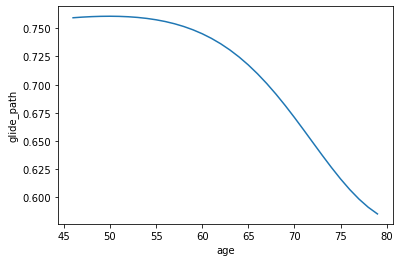

In [222]:
sns.lineplot(x=glide_lst.age, y=glide_lst.glide_path)

---

In [223]:
ID = 10
T = 80 
t_max = 50
t = data.query("ID == {}".format(ID)).iloc[0,3]+1
t_hat = t.copy()
t_max_amt = 300000          # 최전성기 추정 연 저축액 
                           # M_save의 12배가 현재 연 저축액으로 보고 50과 현재나이의 gap에 따라 t_max_amt를 정의
T_amt = 250000              # 은퇴시점 추정 연 저축액
                           # 최전성기 추정 연 저축액의 5/6으로 임의값 정의
    
x =  data.query("ID == {}".format(ID)).iloc[0,5]    # 위험자산의 비율 - 정당성 검사 필요

theta = theta_ftn(x)

mu = 0.04                                    #위험자산의 연 수익률
sigma = 0.2                                  #위험자산의 연 변동성
r = 0.01                                     #무위험자산의 연 이자율 - 고정
X0 = 300000                                  #시점 t에서의 wealth
M_save = data.query("ID == {}".format(ID)).iloc[0,2]/1000          #당월순자산 - 전월순자산

In [224]:
(t, t_max_amt, T_amt, x, X0, M_save)

(50, 300000, 250000, 0.9854399889309952, 300000, 25342.859)

In [225]:
glide_lst = glide_path(t,t_hat, mu, sigma, r, theta, t_max, T, t_max_amt, T_amt, M_save, X0)

In [226]:
glide_lst

,age,m_t,glide_path
0,50,1.884025e+08,0.724002
1,51,1.907646e+08,0.722963
2,52,1.930185e+08,0.721967
3,53,1.951653e+08,0.721013
4,54,1.972063e+08,0.720097
5,55,1.991427e+08,0.719216
6,56,2.009761e+08,0.718368
7,57,2.027080e+08,0.717550
8,58,2.043399e+08,0.716761
9,59,2.058737e+08,0.715998


<AxesSubplot:xlabel='age', ylabel='glide_path'>

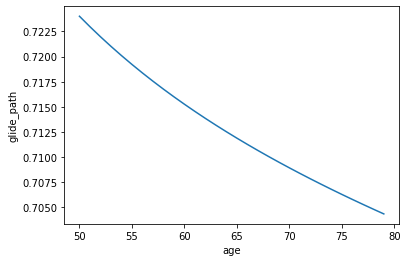

In [227]:
sns.lineplot(x=glide_lst.age, y=glide_lst.glide_path)

---

### ver01.

In [20]:
ID = 10 #data.ID[100]
T = 65 # 생애주기 max
t_max = 50 # 생애주기에서 수익원이 최대인 시점
t = data.query("ID == {}".format(ID)).iloc[0,2]+1
t_max_amt = 5000
T_amt = 30000
t_hat = t.copy()

x =  data.query("ID == {}".format(ID)).iloc[0,4]
theta = np.exp(-7.34*x**3 + 12.13*x**2 + -6.74*x + 1.95) #위험자산 비율을 활용한 수식

mu = 0.08                                    #위험자산의 연 수익률 
sigma = 0.2                                  #위험자산의 연 변동성
r = 0.01                                    #무위험자산의 연 이자율(KOFR) r ---- 고정
x0 = 300000                               #시점 t에서의 wealth
m_sav = data.query("ID == {}".format(ID)).iloc[0,5]/1000                               #당월순자산 - 전월순자산

alpha_bar = (mu -r)/(theta*sigma**2)

In [249]:
theta, m_sav

(1.0752113679656292, 25337.233)

In [250]:
glide = []

if t_hat<t_max:
    while t < T:
        a1 = (t_max_amt-12*m_sav)/(t_max-t_hat)
        b1 = ((12*m_sav - t_max_amt)/(t_max-t_hat))*t_max + t_max_amt
        a2 = (T_amt-t_max_amt)/(T-t_max)
        b2 = (((t_max_amt-T_amt)*T)/(T-t_max))+T_amt     

        m_t = x0*np.exp(alpha_bar*mu*t)+alpha_bar*mu*(a2*(T**2)/2+b2*T+(a1-a2)*(t_max**2)/2+(b1-b2)*t_max)*t-alpha_bar*mu*((a1*t**2)/6+(b1*t)/2)*t+(a1*t/2+b1)*t
        g_t = alpha_bar+(mu*(a1*((t_max**2)-(t**2))/2+b1*(t_max-t)+a2*((T**2)-(t_max**2))/2+b2*(T-t_max)))/(theta*(sigma**2)*m_t)

        print(t,g_t)
        glide.append([t,m_t, g_t])
        t+=1
else:
    while t < T:
        a2 = (T_amt-12*m_sav)/(T-t_hat)
        b2 = T_amt +(12*m_sav-T_amt)/(T-t_hat)

        m_t = x0*np.exp(alpha_bar*mu*t)+alpha_bar*mu*(0.5*a2*(T**2)+b2*T)*t - alpha_bar*mu*(a2*(t**2)*1/6+b2*t*1/2)*t+(a2*t/2+b2)*t
        g_t = alpha_bar+(mu*(0.5*a2*((T**2)-(t**2))+b2*(T-t))/(theta*(sigma**2)*m_t))
        
        print(t, m_t, g_t)
        glide.append([t, m_t, g_t])
        t+=1

50 -7942512.002914067 5.148396475567119
51 17320204.616779417 0.10695332240580435
52 46578743.49524218 1.0977891552601027
53 80377702.12597246 1.3416499136120799
54 119337081.14742023 1.4494811640729295
55 164162770.21316227 1.50884928721807
56 215658492.07013643 1.5455312941817931
57 274739407.62931126 1.5698387339605597
58 342447613.0132108 1.5867005834132317
59 419969791.686341 1.5987677750080795
60 508657321.3631696 1.6075912809034298
61 610049177.0650938 1.614137673074832
62 725898019.1703067 1.6190395876215786
63 858199909.3747354 1.6227275661697627
64 1009228159.0762228 1.6255040232488294


In [251]:
glide = pd.DataFrame(glide)
if t_hat<t_max:
    glide.columns = ['age','m_t','glide_path']
else:
    glide.columns = ['age','m_t','glide_path']

glide['glide_path'] = glide.glide_path.astype(float)

<AxesSubplot:xlabel='age', ylabel='glide_path'>

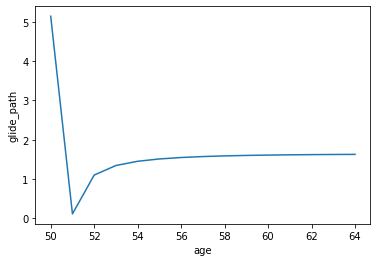

In [252]:
sns.lineplot(x=glide.age, y=glide.glide_path)

In [253]:
glide

,age,m_t,glide_path
0,50,-7.942512e+06,5.148396
1,51,1.732020e+07,0.106953
2,52,4.657874e+07,1.097789
3,53,8.037770e+07,1.341650
4,54,1.193371e+08,1.449481
5,55,1.641628e+08,1.508849
6,56,2.156585e+08,1.545531
7,57,2.747394e+08,1.569839
8,58,3.424476e+08,1.586701
9,59,4.199698e+08,1.598768


---